In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os

zip_path = "/content/drive/MyDrive/gagandeep.zip"
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(" Dataset extracted.")

 Dataset extracted.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_dir = "/content/dataset/gagandeep/train"
val_dir = "/content/dataset/gagandeep/val"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest')

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 712 images belonging to 2 classes.
Found 848 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers
for layer in base_model.layers[:600]:
    layer.trainable = False

# Unfreeze later layers for fine-tuning
for layer in base_model.layers[600:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build((None, 224, 224, 3))

# Callbacks — No EarlyStopping used
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_resnet152_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Fit the model for all 51 epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=21,
    callbacks=[checkpoint, lr_scheduler]  # early_stop removed
)


Epoch 1/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.3165 - loss: 1.7748
Epoch 1: val_loss improved from inf to 1.62546, saving model to /content/drive/MyDrive/best_resnet152_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3180 - loss: 1.7741 - val_accuracy: 0.0024 - val_loss: 1.6255 - learning_rate: 1.0000e-04
Epoch 2/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3827 - loss: 1.7015
Epoch 2: val_loss improved from 1.62546 to 1.57014, saving model to /content/drive/MyDrive/best_resnet152_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3825 - loss: 1.7022 - val_accuracy: 0.1073 - val_loss: 1.5701 - learning_rate: 1.0000e-04
Epoch 3/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.4338 - loss: 1.6667
Epoch 3: val_loss improved from 1.57014 to 1.52717, saving model to /content/drive/MyDrive/best_resnet152_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4340 - loss: 1.6654 - val_accuracy: 0.3184 - val_loss

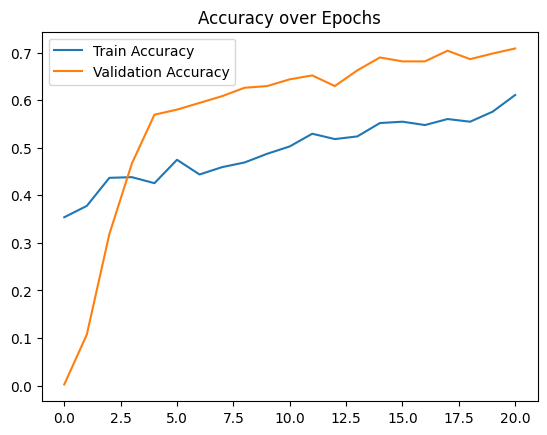

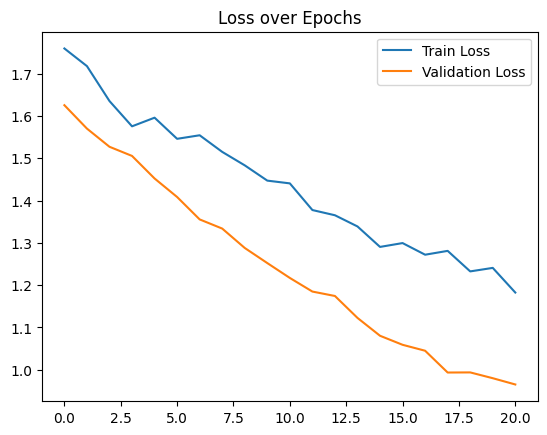

In [ ]:
import matplotlib.pyplot as plt
import os

graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title("Accuracy over Epochs")
plt.savefig(f"{graph_dir}/accuracy_plot.png")
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title("Loss over Epochs")
plt.savefig(f"{graph_dir}/loss_plot.png")
plt.show()


✅ Model loaded from: /content/drive/MyDrive/best_resnet152_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 851ms/step
Unique y_true: [0 1]
Unique y_pred: [0 1 3]
Valid labels: [0, 1]
Target names: ['abnormal', 'normal']

Predicted sample count per class:
abnormal: 252
normal: 595

✅ Overall Validation Accuracy: 70.52%


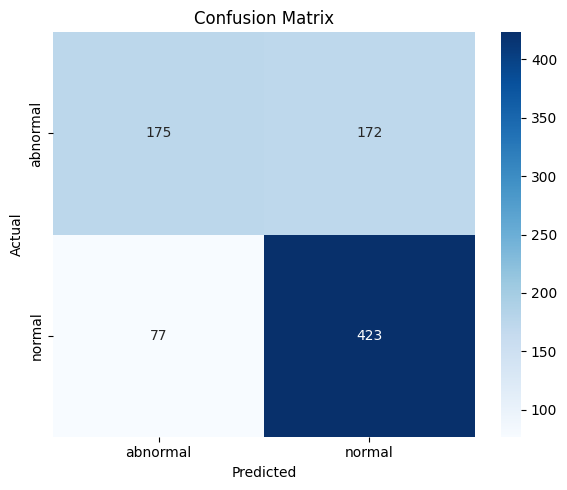


Classification Report:

              precision    recall  f1-score   support

    abnormal       0.69      0.50      0.58       348
      normal       0.71      0.85      0.77       500

   micro avg       0.71      0.71      0.71       848
   macro avg       0.70      0.67      0.68       848
weighted avg       0.70      0.71      0.69       848



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import load_model

# === Load the trained ResNet152 model ===
model_path = "/content/drive/MyDrive/best_resnet152_model.keras"
model = load_model(model_path)
print("✅ Model loaded from:", model_path)

# === Directory to save plots ===
graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# === Predict on validation data ===
val_data.reset()
pred_probs = model.predict(val_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_data.classes

# === Get class mapping ===
class_indices = val_data.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
valid_labels = sorted(index_to_label.keys())
target_names = [index_to_label[i] for i in valid_labels]

# === Debug info ===
print("Unique y_true:", np.unique(y_true))
print("Unique y_pred:", np.unique(y_pred))
print("Valid labels:", valid_labels)
print("Target names:", target_names)

# === Optional: Check class prediction counts ===
print("\nPredicted sample count per class:")
pred_counter = collections.Counter(y_pred)
for label in valid_labels:
    print(f"{index_to_label[label]}: {pred_counter.get(label, 0)}")

# === Accuracy Score ===
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Validation Accuracy: {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{graph_dir}/confusion_matrix.png")
plt.show()

# === Classification Report ===
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=valid_labels,
    target_names=target_names,
    zero_division=0  # Prevents warnings when precision is undefined
))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


IndexError: list index out of range

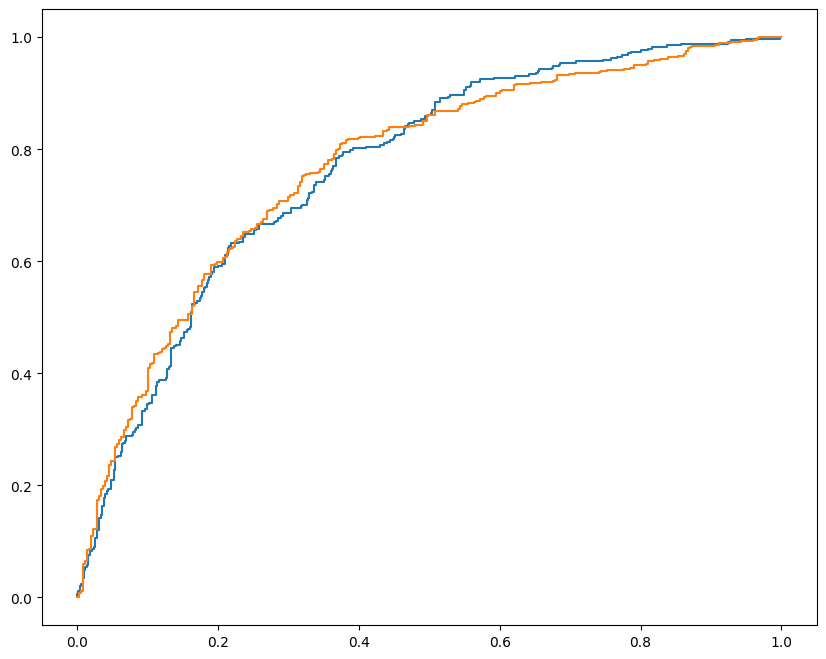

In [ ]:
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=[0,1,2,3,4])
fpr = {}; tpr = {}; roc_auc = {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f"{graph_dir}/roc_curve.png")
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/final_resnet152_model.keras")